In [56]:
from qresearch.universe.hsci import canon_hk_ticker, build_hsci_events_from_history
from qresearch.data.io import load_market_data_from_parquet, load_historical_mcap_parquet, load_hsci_2008_components, \
    load_hsci_components_history
from qresearch.data.utils import get_processed_dir
import pandas as pd

history_df = load_hsci_components_history("hsci_components_history.csv")  # processed
events = build_hsci_events_from_history(history_df)

snap2008 = load_hsci_2008_components("hsci_components_2008.csv")  # raw
seed_members = set(
    snap2008["Stock Code"]
    .map(canon_hk_ticker)
    .dropna()
    .astype(str)
    .unique()
)

md = load_market_data_from_parquet(get_processed_dir() / 'market/hsci_ohlc.parquet')
mcap = load_historical_mcap_parquet(get_processed_dir() / 'fundamentals/hsci_mkt_cp.parquet')

In [57]:
from qresearch.universe.builder import build_final_universe_eligible
from qresearch.universe.filters import UniverseFilterConfig

uf_cfg = UniverseFilterConfig(
    ma_window=21,
    min_ma_price=1.0,      # None disables
    mcap_window=21,
    min_mean_mcap=1e9,     # None disables; requires mcap if not None
    min_ipo_trading_days=63,  # 0 disables
)

universe_eligible = build_final_universe_eligible(
    close=md.close,
    events=events,                # membership gating ON
    seed_members=seed_members,
    cfg=uf_cfg,
    mcap=mcap,                    # required if min_mean_mcap is not None
    effective_on_close=True,
)
# universe_eligible: bool DataFrame (date x ticker)


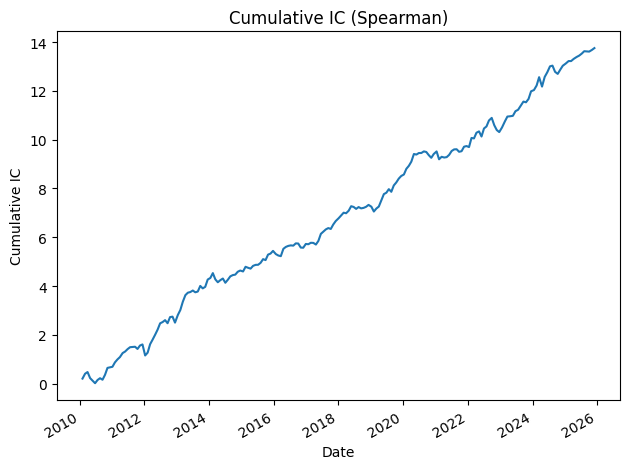

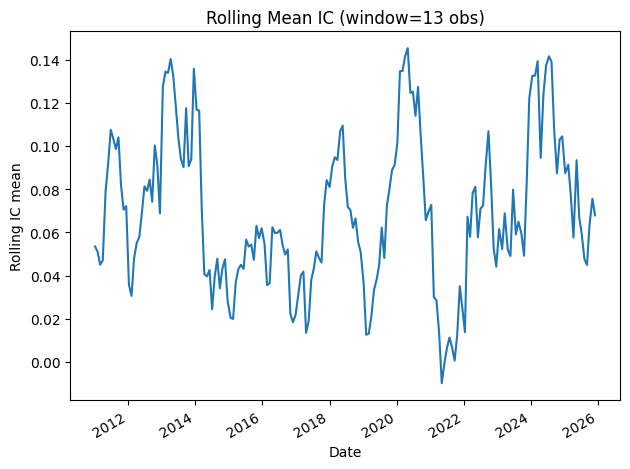

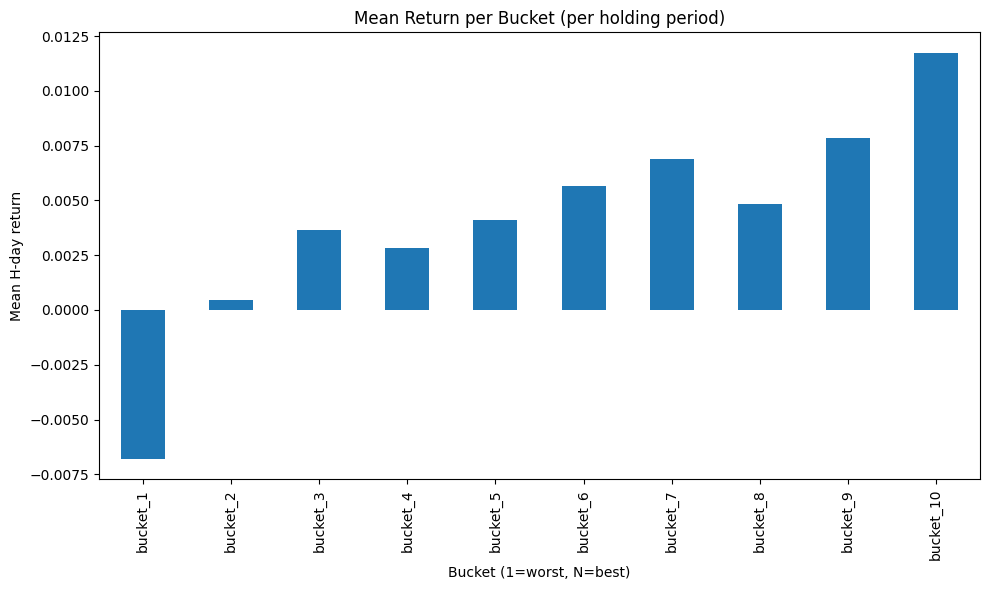

<Figure size 640x480 with 0 Axes>

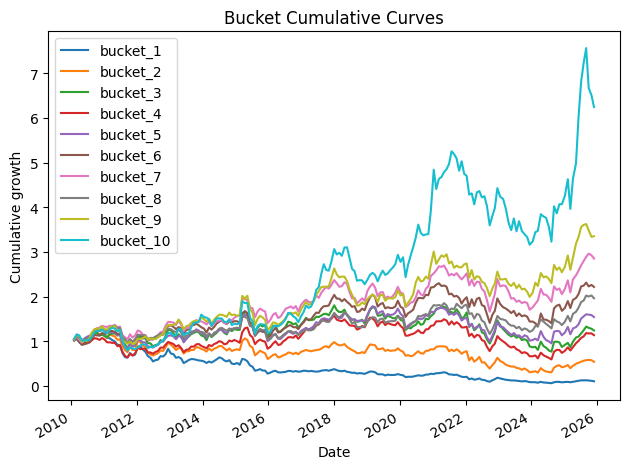

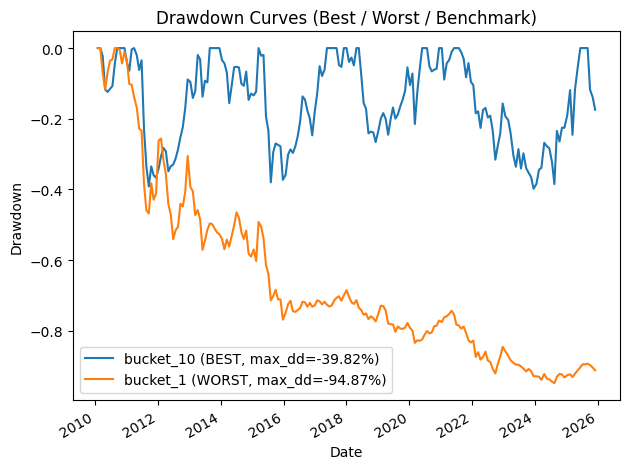

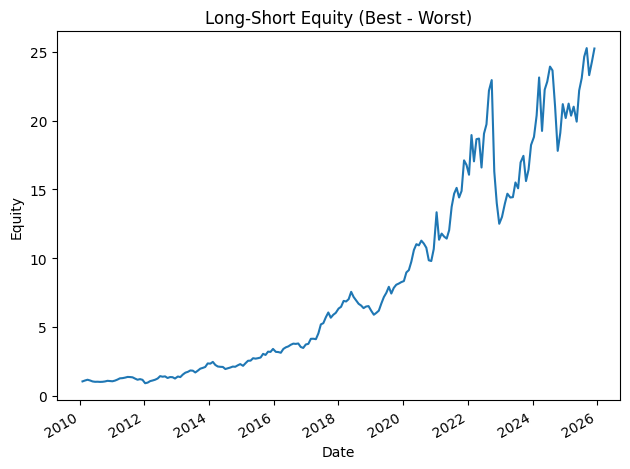

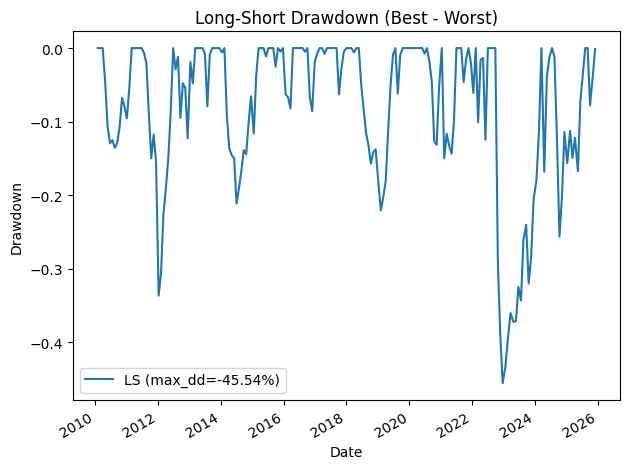

<Figure size 1000x500 with 0 Axes>

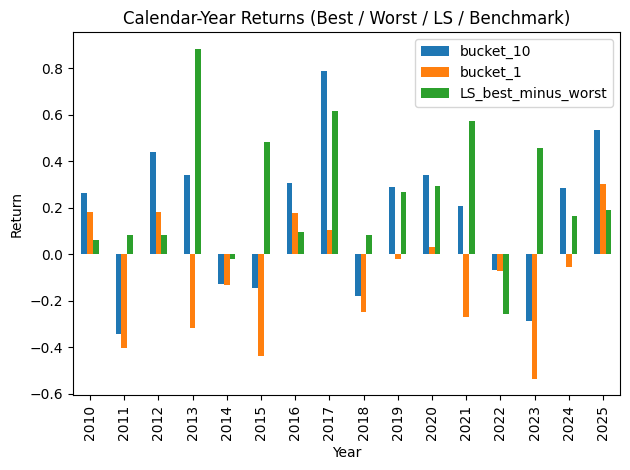

In [58]:
from qresearch.signals.registry import compute_signal
from qresearch.backtest.buckets import make_tearsheet


sig = compute_signal(md, name="trend_annret_r2", lookback=252, ann_factor=252, skip=21)
sig = sig.reindex(index=md.close.index, columns=md.close.columns)


rep = make_tearsheet(
    md=md,
    signal=sig,
    H=20,
    n_buckets=10,
    entry_mode="next_close",
    min_assets_ic=50,
    plot=True,
    benchmark_price=None,
    benchmark_name="Benchmark",
    universe_eligible=universe_eligible,  # critical
)


In [59]:
from qresearch.signals.signals_sweep import *

test_ma_diff = [
    ('ma_diff', {"lookback": 5, 'sign': -1}),
    ('ma_diff', {"lookback": 20, "skip": 2}),
    ('ma_diff', {"lookback": 120, "skip": 12}),
    # ('ma_diff', {"lookback": 200, "skip": 0}),
    ('ma_diff', {"lookback": 250, "skip": 21}),
]

test_mom_ret = [
    ("mom_ret", {"lookback": 5}),
    ("mom_ret", {"lookback": 21}),
    ("mom_ret", {"lookback": 126, "skip": 12}),
    ("mom_12_1", {"lookback": 252, "skip": 21}),
]

test_ohlc_mom = [
    ("on_minus_id", {"lookback": 5, 'sign': -1}),
    ("overnight_mom", {"lookback": 5, 'sign': -1}),
    ('intraday_mom', {"lookback": 5, 'sign': -1}),
    ("on_minus_id", {"lookback": 10, 'sign': -1}),
    ("overnight_mom", {"lookback": 10, 'sign': -1}),
    ('intraday_mom', {"lookback": 10, 'sign': -1}),
    # ("on_minus_id", {"lookback": 21}),
    # ("overnight_mom", {"lookback": 21}),
    # ('intraday_mom', {"lookback": 21}),
    # ("on_minus_id", {"lookback": 63}),
    # ("overnight_mom", {"lookback": 63}),
    # ('intraday_mom', {"lookback": 63}),
    ("on_minus_id", {"lookback": 126}),
    ("overnight_mom", {"lookback": 126}),
    ('intraday_mom', {"lookback": 126, 'sign': -1}),
    ("on_minus_id", {"lookback": 252}),
    ("overnight_mom", {"lookback": 252}),
    ('intraday_mom', {"lookback": 252, "sign": -1}),
]

test_rsi = [
    ("rsi", {"lookback": 5}),
    ("rsi", {"lookback": 12}),
    ("rsi", {"lookback": 24}),
]

test_trend_annret_r2 = [
    ("trend_annret_r2", {"lookback": 126, "ann_factor": 252, 'skip': 21}),
    ("trend_annret_r2", {"lookback": 252, "ann_factor": 252, 'skip': 21}),
]

tests = test_ma_diff + test_mom_ret + test_trend_annret_r2 + test_ohlc_mom + test_rsi

In [60]:
cfg = SignalTestConfig(
    H=20,
    n_buckets=10,
    entry_mode="next_close",
    min_assets_ic=50,
)

df = sweep_signals(
    md=md,
    tests=tests,
    cfg=cfg,
    universe_eligible=universe_eligible,  # pass once
)

In [ ]:
df

In [ ]:
cfg = SignalTestConfig(
    H=5,
    n_buckets=10,
    entry_mode="next_open",
    min_assets_ic=50,
)

df = sweep_signals(
    md=md,
    tests=tests,
    cfg=cfg,
    universe_eligible=universe_eligible,  # pass once
)

df

In [ ]:
sig = compute_signal(md, name="overnight_mom", lookback=10, sign=-1)
sig = sig.reindex(index=md.close.index, columns=md.close.columns)


rep = make_tearsheet(
    md=md,
    signal=sig,
    H=5,
    n_buckets=10,
    entry_mode="next_open",
    min_assets_ic=50,
    plot=True,
    benchmark_price=None,
    benchmark_name="Benchmark",
    universe_eligible=universe_eligible,  # critical
)